In [1]:
import sys
from pathlib import Path

# Add the src directory to Python path
src_path = str(Path("./").resolve().parent.parent)
if src_path not in sys.path:
    sys.path.append(src_path)

sys.path

from collections import defaultdict

import pandas as pd

from src.classifying import (
    ActivationsHandler,
    combine_activations_handlers,
    get_correctness_direction_classifier,
    get_logistic_regression_classifier,
    get_between_class_variance_and_within_class_variance,
)
# from src.visualisations.utils import plot_interactive_lineplot
from src.utils.data import load_activations, load_labels, get_experiment_activations_configs_df_subset

In [2]:
models = [
    "ministral_8b_instruct",
    "qwen_2.5_7b_instruct",
    "llama3.1_8b_chat",
    "llama3.3_70b",
    "deepseek_qwen_32b",
    "mistral_7b_instruct",
]

BASE_PATH = {}
BASE_PATH["llama3.1_8b_chat"] = "/runpod-volume/anton/correctness-model-internals/data_for_classification"
BASE_PATH["llama3.3_70b"] = "/runpod-volume/arnau/correctness-model-internals/data_for_classification"
BASE_PATH["deepseek_qwen_32b"] = "/runpod-volume/arnau/correctness-model-internals/data_for_classification"
BASE_PATH["mistral_7b_instruct"] = "/runpod-volume/anton/correctness-model-internals/data_for_classification"
BASE_PATH["ministral_8b_instruct"] = "/runpod-volume/arnau/correctness-model-internals/data_for_classification"
BASE_PATH["qwen_2.5_7b_instruct"] = "/runpod-volume/arnau/correctness-model-internals/data_for_classification"

layers = {}
layers["llama3.1_8b_chat"] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
layers["llama3.3_70b"] = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76]
layers["deepseek_qwen_32b"] = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]
layers["mistral_7b_instruct"] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
layers["ministral_8b_instruct"] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
layers["qwen_2.5_7b_instruct"] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]

aurocs = {}
aurocs["llama3.1_8b_chat"] = {}
aurocs["llama3.3_70b"] = {}
aurocs["deepseek_qwen_32b"] = {}
aurocs["mistral_7b_instruct"] = {}
aurocs["ministral_8b_instruct"] = {}
aurocs["qwen_2.5_7b_instruct"] = {}

In [ ]:
for model_id in models:
    print(model_id)
    BASE_PATH_MODEL = BASE_PATH[model_id]
    dataset_id = "trivia_qa_2_60k"
    prompt_id = "base"
    subset_id = "main"
    input_type = "prompt_only"
    n_folds = 3
    layers_model = layers[model_id]
    best_auc = -1
    best_layer = None
    for layer in layers_model:
        activations, indices = load_activations(
            base_path=BASE_PATH_MODEL,
            model_id=model_id,
            dataset_id=dataset_id,
            prompt_id=prompt_id,
            subset_id=subset_id,
            input_type=input_type,
            layer=layer,
        )
        labels_df = load_labels(
            base_path=BASE_PATH_MODEL,
            model_id=model_id,
            dataset_id=dataset_id,
            prompt_id=prompt_id,
            subset_id=subset_id,
        )
        activations, indices, labels_df = activations[:10000], indices[:10000], labels_df.iloc[:10000]
        activations_handler = ActivationsHandler(
            activations=activations,
            labels=labels_df["correct"].astype(bool),
        )
        activations_handler_folds = list(
            activations_handler.split_dataset(split_sizes=[1/n_folds] * n_folds)
        )
        test_aurocs = []
        for i in range(n_folds):
            activations_handler_test = activations_handler_folds[i]
            activations_handler_train = combine_activations_handlers(
                [ah for j, ah in enumerate(activations_handler_folds) if j != i]
            )
            activations_handler_train = activations_handler_train.sample_equally_across_groups(
                group_labels=[False, True]
            )
            activations_handler_test = activations_handler_test.sample_equally_across_groups(
                group_labels=[False, True]
            )
            direction_classifier, direction_calculator = get_correctness_direction_classifier(
                activations_handler_train=activations_handler_train,
                activations_handler_test=activations_handler_test,
            )
            test_aurocs.append(direction_classifier.classification_metrics['test_roc_auc'])
        print(layer, "AUROC", sum(test_aurocs) / len(test_aurocs))
        aurocs[model_id][layer] = sum(test_aurocs) / len(test_aurocs)
        if sum(test_aurocs) / len(test_aurocs) > best_auc:
            best_auc = sum(test_aurocs) / len(test_aurocs)
            best_layer = layer
    print("Best layer", best_layer, "Best AUROC", best_auc)
    print()

ministral_8b_instruct


In [3]:
# For minstral_8b_instruct
trivia_auc_minstral_8b_instruct = {
    0: 0.5495403846187068,
    2: 0.548792635012618,
    4: 0.5787542271264629,
    6: 0.6097800623535635,
    8: 0.6421323052770836,
    10: 0.6707838446279281,
    12: 0.6926807966441167,
    14: 0.717728457413498,
    16: 0.7205365987524677,
    18: 0.7246751152428915,
    20: 0.7223068688747557,
    22: 0.7137682831199302,
    24: 0.7112653319083732,
    26: 0.7169729881434305,
    28: 0.7174440123728801,
    30: 0.7170896431084146,
    32: 0.7093751088292612,
    34: 0.7061607015380144,
}

# For qwen_2.5_7b_instruct
trivia_auc_qwen_2_5_7b_instruct = {
    0: 0.612038945168718,
    2: 0.5951051570164658,
    4: 0.6078613116373252,
    6: 0.6064239277936276,
    8: 0.6494959271318939,
    10: 0.6710583886253173,
    12: 0.68682090907410732,
    14: 0.7052760953296647,
    16: 0.7283449993147024,
    18: 0.753991668476678,
    20: 0.7633225837353707,
    22: 0.7646402945662775,
    24: 0.7341534006207377,
    26: 0.7298260962458985,
}

# For deepseek_qwen_32b
trivia_auc_deepseek_qwen_32b = {
    0: 0.5522582727052087,
    4: 0.5702206277683827,
    8: 0.6066736261457167,
    12: 0.604602097015253,
    16: 0.6210474027030436,
    20: 0.6429718531986993,
    24: 0.6631277501808243,
    28: 0.6865309737814566,
    32: 0.6886038814297937,
    36: 0.6798429566792372,
    40: 0.6900358160826556,
    44: 0.7141600896127799,
    48: 0.707818331587387,
    52: 0.7128457289334474,
    56: 0.6836861894710387,
    60: 0.6661335120684656,
}

# For mistral_7b_instruct
trivia_auc_mistral_7b_instruct = {
    0: 0.590510650129381,
    2: 0.6124375774721246,
    4: 0.592658328952287,
    6: 0.6114785029814438,
    8: 0.6468838910443711,
    10: 0.6953279693941651,
    12: 0.7384472939853219,
    14: 0.7759820890903301,
    16: 0.7880439976223096,
    20: 0.7631375767891856,
    22: 0.762742373474505,
    24: 0.7624422482326052,
    26: 0.746661955293404,
    28: 0.7516009990088973,
    30: 0.7529536470617728,
}

# For llama3_1_8b_chat
trivia_auc_llama3_1_8b_chat = {
    0: 0.580010501801279,
    2: 0.5928773714078985,
    4: 0.6464401240162497,
    6: 0.6630325460622533,
    8: 0.6746670444488511,
    10: 0.7260249749201157,
    12: 0.7664734925522453,
    14: 0.7857046217178758,
    16: 0.7846333582545242,
    18: 0.7734183762766212,
    20: 0.7491349813326916,
    22: 0.7539199859813066,
    24: 0.7570302402474912,
    26: 0.7658013231976605,
    28: 0.7694259078000832,
    30: 0.7527293093307798,
}

# For llama3_3_70b
trivia_auc_llama3_3_70b = {
    0: 0.5848558095777557,
    4: 0.5060030425037334,
    8: 0.6064385575117194,
    12: 0.6350668962966024,
    16: 0.7363973929771576,
    20: 0.7575547392197567,
    24: 0.7609937901392416,
    28: 0.7822171020656962,
    32: 0.8185178127451535,
    36: 0.8141807931038112,
    40: 0.8187002302175598,
    44: 0.8164298174187956,
    48: 0.8152588108937951,
    52: 0.8106765691780208,
    56: 0.796189087550591,
    60: 0.7812482916464641,
    64: 0.770261113326395,
    68: 0.7729600642779252,
    72: 0.8111228454525808,
    76: 0.8338054776565839,
}


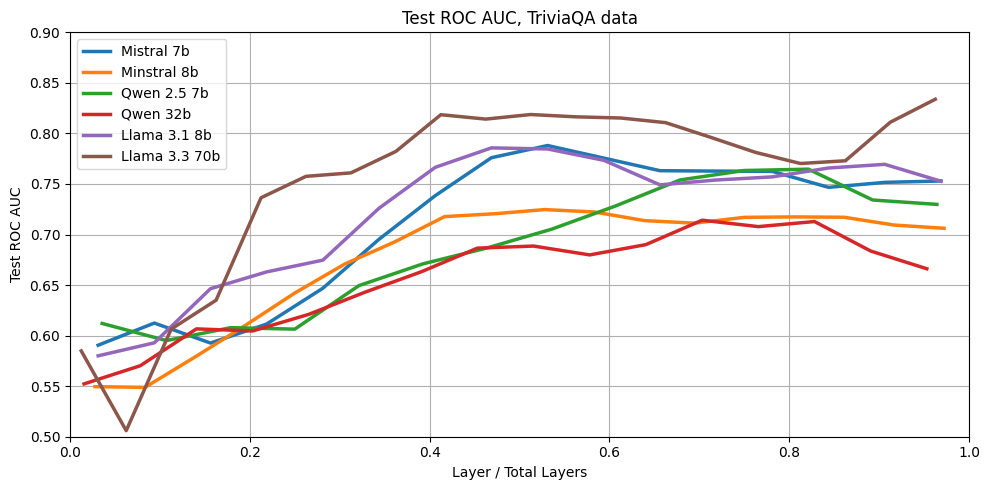

In [12]:
import matplotlib.pyplot as plt

# Reuse your previously defined AUROC dictionaries
trivia_auc_data = {
    "Mistral 7b": trivia_auc_mistral_7b_instruct,
    "Minstral 8b": trivia_auc_minstral_8b_instruct,
    "Qwen 2.5 7b": trivia_auc_qwen_2_5_7b_instruct,
    "Qwen 32b": trivia_auc_deepseek_qwen_32b,
    "Llama 3.1 8b": trivia_auc_llama3_1_8b_chat,
    "Llama 3.3 70b": trivia_auc_llama3_3_70b,
}

# Plotting
plt.figure(figsize=(10, 5))

for model, data in trivia_auc_data.items():
    separation = min(k for k in data if k != 0)  # Determine layer stride
    max_layer = max(data) + separation           # Estimate total layers
    x = [(layer+1) / max_layer for layer in data]
    y = list(data.values())
    plt.plot(x, y, label=model, linewidth=2.5)

plt.xlabel("Layer / Total Layers")
plt.ylabel("Test ROC AUC")
plt.title("Test ROC AUC, TriviaQA data")
plt.ylim(0.5, 0.9)
plt.xlim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
